# Storing and recalling MNIST digits with Hopfield nets

In [1]:
%matplotlib inline
from pylab import *

Let us implement a Hopfield network using images from [the MNIST dataset](http://nbviewer.ipython.org/github/francesco-mannella/neunet-basics/blob/master/course/mnist.ipynb) as patterns.

#### Initialize the dataset
First we initialize the dataset:

In [2]:
#### Download the dataset 
# Get the script from internet
! wget https://raw.githubusercontent.com/sorki/python-mnist/master/get_data.sh > /dev/null 2>&1  

# Run it to dovnload all files in a local dir named 'data'
! bash get_data.sh >/dev/null 2>&1

# We do not need the script anymore, remove it
! rm get_data.sh* > /dev/null 2>&1

# Initialize the dataset variables
%run utils

We now fill a array with all parameters. We only need few samples, we take them from the training set. 
We take samples 2 and 5, representing respectively a '4' and a '2'

In [3]:
# Take two rows
patterns = array(mndata.train_images)[[2,5],]
labels = array(mndata.train_labels)[[2,5],]

# We need only the sign (transform to binary input)
patterns = sign(patterns/255.0 - 0.5)

# Set the number of patterns (two in out case)
n_patterns = patterns.shape[0]

# Number of units of the network
n = img_side*img_side

Let us visualize our two patterns:

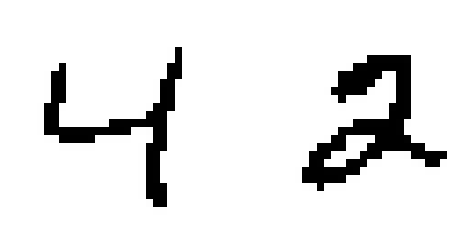

In [4]:
fig = figure(figsize = (8, 4))
for i in xrange(n_patterns):
    plot_img( to_mat(patterns[i]), 
             fig, i+1, windows = 2 )

#### Learning the weights

Learning of the weight happens offline at the beginning, in one shot:

In [5]:
# Initialize weights to zero values
W = zeros([n,n])

# Accumulate outer products 
for pattern in patterns :
    W += outer(pattern, pattern)

# Divide times the number of patterns
W /= float(n_patterns)

# Exclude the autoconnections
W *= 1.0 - eye(n, n)

#### Recall: Iterating the timesteps

Now we implement the recall part, in which we give an initial activation to the network and iterate the timesteps unitil it relaxes to a steady state.

In [6]:
# Number of timesteps
stime = 1000

# Number of samples to store as long 
# as spreading goes on
samples = 100

# store data at each sampling interval
sample_interval = stime/samples

# Init the stories of spreading as a zero array,
# we will fill it in at each timestep and we will 
# plot it at the end
store_images = zeros([n_patterns, n, samples])

# Init the stories of energy as a zero array,
# we will fill it in at each timestep and we will 
# plot it at the end
store_energy = zeros([n_patterns, samples])

# We simulate two iterations, each one starting
# with a coorupted version of one of our two patterns
for target_index in xrange(n_patterns) :

    # Copy the original pattern
    target = patterns[target_index]
    x = target.copy()
    
    # Then modify the second half of the image 
    # putting random binary values
    x[(n/2):] = sign(randn(n/2))

    
    # During the iterations we need to peek 
    # one unit at random. Thus we must prepare
    # a random sequence of indices:
    #    we get the sequence of indices 
    #    of the network units
    x_indices = arange(n)
    
    #    and we shuffle it
    shuffle(x_indices)
    
    # the iterations
    for t in xrange(stime) :
        # Get the current index browsing 
        # the random sequence 
        current_x = x_indices[t%n]   
        
        # Activation of a unit
        x[current_x] = sign(dot(W[current_x,:], x))
        
        # Store current activations
        if stime%sample_interval == 0 :
            # Energy of the current state of the network
            store_energy[target_index, t/sample_interval] = -0.5*dot(x, dot(W, x))
            
            # array containing samples of network activation
            store_images[target_index,:,t/sample_interval] = x


Here you can see two animations showing the network that is initially activated with one of the two patterns. The initial activation is corrupted with a lot of noise so that the bottom half of the figure is completelly obscured. 
The network moves from this initial activation to the correct attractor state (the original uncorrupted figure). During this process the energy of the network lowers untill it reaches a steady state.

<img src="mnist-hopfield_4.gif" width=100%>
<img src="mnist-hopfield_2.gif" width=100%>

####  Appendix: How to build the animation
We use the [matplotlib.animation](http://matplotlib.org/api/animation_api.html) package for animations and the [gridspec](http://matplotlib.org/users/gridspec.html) class to customize the layout of subplots. 

In [7]:
# The matplotlib object to do animations
from matplotlib import animation

# This grid allows to layout subplots in a more
# flexible way
import matplotlib.gridspec as gridspec

To plot the two animations we need a function to initialize a figure with three plots: the first showing the target digit, the second showing the current activity of the network and the third showing the sum of squared errors. 

In [8]:
def init_figure(fig) :

    # Init the grid and the figure
    gs = gridspec.GridSpec(6, 20)

    #-------------------------------------------------
    # Plot 1 - plot the target digit

    # Create subplot
    ax1 = fig.add_subplot(gs[:4,:4])

    title("target")

    # Create the imshow and save the handler
    im_target = ax1.imshow(to_mat(patterns[0]), 
            interpolation = 'none', 
            aspect = 'auto',
            cmap = cm.binary) 
    axis('off')


    #-------------------------------------------------
    # Plot 2 - plot the current state of the network

    # Create subplot
    ax2 = fig.add_subplot(gs[:4,6:10])

    title("recalling")

    # Create the imshow and save the handler
    im_activation = ax2.imshow(to_mat(store_images[0,:,0]), 
            interpolation = 'none', 
            aspect = 'auto',
            cmap = cm.binary) 
    axis('off')

    #-------------------------------------------------
    # Plot 3 - plot the current history of energy

    # Create subplot
    ax3 = fig.add_subplot(gs[:4,12:])

    title("Energy")

    # Create the line plot and save the handler
    im_energy, = ax3.plot(store_energy[0,])

    # Only bottom-left axes - no tics
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xticks([])
    ax3.set_yticks([])   
    
    # return plot handlers
    return im_target, im_activation, im_energy

We also need one another function that updates the figure at 
each animation timestep with a new sample

In [9]:
# Updates images at each frame of the animation
# data    : list of tuples    Each row contains the
#                             arguments of update for 
#                             a frame
# returns : tuple             The handlers of the 
#                             images 
def update(data) :

    # unpack plot handlers and data 
    im_A, im_B, im_C, A, B, C = data
    
    # Update data of plot 1, plot 2 and 3
    im_A.set_array(to_mat(A))
    im_B.set_array(to_mat(B))
    im_C.set_data(arange( len(C)), C)  
    
    # return plot handlers
    return im_A, im_B, im_C

Finally we use the FuncAnimation class. We first build a data list where each row is a tuple containing plot handlers and data do for plot updates..

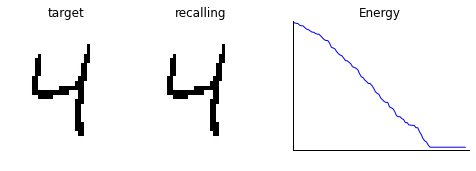

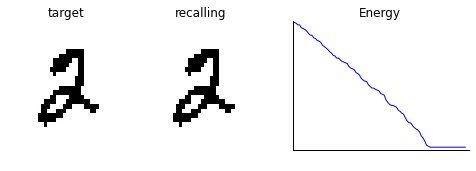

In [10]:
for target_index in xrange(n_patterns):

    # Init the figure
    fig = figure(figsize=(8, 3.5))      
    
    im_target, im_activation, im_energy = init_figure(fig)
    
    # Build the sequence of update arguments.
    # each row of the list contains:
    # 1 the target plot handler
    # 2 the activation plot handler
    # 3 the energy plot handler
    # 4 the target update data
    # 5 the activation update data
    # 6 the energy update data
    data = [(
            im_target, 
            im_activation, 
            im_energy,
            patterns[target_index],
            squeeze(store_images[target_index,:,t]), 
            store_energy[target_index, :t] ) 
        for t in xrange(samples ) ]

    # Create and render the animation
    anim = animation.FuncAnimation(fig, func = update,  frames = data )
    # save it to file
    anim.save("mnist-hopfield_{:d}.gif".format(labels[target_index]),
              fps = 10, writer='imagemagick')


<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
Next cell is just for styling

In [11]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/ipybn.css", "r").read()
    return HTML(styles)
css_styling()